In [1]:
import torch
from torch import nn
from torch import optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from sklearn.gaussian_process import GaussianProcessRegressor as GPR
from sklearn.gaussian_process.kernels import RBF, WhiteKernel
!pip install torchdiffeq
from torchdiffeq import odeint_adjoint, odeint
import numpy as np
from scipy import io
import argparse
import os
import pickle
import matplotlib.pyplot as plt
from timeit import default_timer
from google.colab import drive
drive.mount('/content/drive')
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Mounted at /content/drive


In [2]:
directory = "drive/MyDrive/"#"spring-runs_train/" #/mnt/data/datasets/physical_system_benchmark/experiment_output/spring/spring/run/data_gen/spring-runs_train-spring-n1000-t805-n0_00001/"
npz = np.load(directory + "trajectories_wave.npz")
nb_trajs = 50
start_traj = 0
nb_times = 10205
x_width = 125
p1, q1, dqdt1, dpdt1, t1 = np.zeros((nb_trajs,x_width,nb_times)), np.zeros((nb_trajs,x_width,nb_times)), np.zeros((nb_trajs,x_width,nb_times)), np.zeros((nb_trajs,x_width,nb_times)), np.zeros((nb_trajs,x_width,nb_times))
for i in range(start_traj, start_traj + nb_trajs):
  p1[i,:,:], q1[i,:,:], dqdt1[i,:,:], dpdt1[i,:,:], t1[i,:,:] = npz[npz.files[5*i+0]].T, npz[npz.files[5*i+1]].T, npz[npz.files[5*i+2]].T, npz[npz.files[5*i+3]].T, npz[npz.files[5*i+4]].T
q_exact = torch.tensor(q1, dtype = torch.float32)
p_exact = torch.tensor(p1, dtype = torch.float32)
t = torch.tensor(t1[0], dtype = torch.float32)
exact = torch.cat((q_exact.reshape(nb_trajs,x_width,nb_times,1), p_exact.reshape(nb_trajs,x_width,nb_times,1)), dim=-1)

In [3]:
test_trajs = 16
train_loader = DataLoader(exact[:(nb_trajs-test_trajs)], batch_size=16)
test_loader  = DataLoader(exact[(nb_trajs-test_trajs):], batch_size=16)

In [4]:
print(exact.shape)
print(len(exact[(nb_trajs-test_trajs):]))

torch.Size([50, 125, 10205, 2])
16


In [5]:
class Lyapunov(nn.Module):
  def __init__(self, in_nodes, layers, activation):
    super(Lyapunov, self).__init__()
    self.in_nodes = in_nodes
    self.layers = layers
    self.act = activation
    self.w0 = nn.Linear(in_nodes, in_nodes)
    self.w1 = nn.Linear(in_nodes, 1)
    self.u1 = nn.Parameter(torch.Tensor(1, in_nodes))
    nn.init.xavier_uniform_(self.u1)
    self.g0 = self.g(torch.zeros(in_nodes))
  def g(self, x):
    z = self.act(self.w0(x))
    z = self.act(self.w1(x)  + F.linear(z, self.u1.exp()))
    return z
  def forward(self, x):
    return self.act(self.g(x) - self.g0) + torch.sum(x**2, dim=1).reshape(-1,1)/100
# class Lyapunov(nn.Module):
#   def __init__(self, in_nodes, layers, activation):
#     super(Lyapunov, self).__init__()
#     self.in_nodes = in_nodes
#     self.layers = layers
#     self.act = activation
#     self.W = [nn.Linear(in_nodes, in_nodes)]
#     self.U = []
#     for i in range(layers):
#       self.W.append(nn.Linear(in_nodes, in_nodes))
#       self.U.append(nn.Linear(in_nodes, in_nodes))
#     self.W.append(nn.Linear(in_nodes, 1))
#     self.U.append(nn.Linear(in_nodes, 1))
#     self.g0 = self.g(torch.zeros(in_nodes))
#   def g(self, x):
#     z = self.act(self.W[0](x))
#     for i in range(self.layers):
#       z = self.act(self.W[i+1](x) + self.U[i](z)**2)
#     z = self.act(self.W[self.layers+1](x) + self.U[self.layers](z)**2)
#     return z
#   def forward(self, x):
#     return self.act(self.g(x) - self.g0) + torch.norm(x, p=2)/100

In [6]:
class ODEFunc(nn.Module):
    def __init__(self, in_nodes, hid_nodes, v_layers, v_act):
        super(ODEFunc, self).__init__()
        self.fc0 = nn.Linear(in_nodes+1, hid_nodes)
        self.fc1 = nn.Linear(hid_nodes, in_nodes)
        self.V = Lyapunov(in_nodes, v_layers, v_act)
    def forward(self, t, x):
        x = x.requires_grad_(True)
        tt = torch.ones_like(x[...,:1], requires_grad=True)*t
        xt = torch.cat((tt, x), dim=-1)
        fx = self.fc0(xt)
        fx = F.gelu(fx)
        fx = self.fc1(fx)
        # Vx = self.V(x)
        # grad_Vx = torch.autograd.grad(Vx, x, torch.ones(Vx.shape), create_graph=True, allow_unused=True, retain_graph=True)[0]
        # alpha = 1
        # fx = fx - grad_Vx*torch.relu(torch.sum(grad_Vx*fx,dim=1).reshape(-1,1) + alpha*Vx)/torch.sum(grad_Vx**2, dim=1).reshape(-1,1)
        return fx

In [7]:
class NODE(nn.Module):
    def __init__(self, in_nodes, hid_nodes, tol, v_layers, v_act):
        super(NODE, self).__init__()
        self.ode = ODEFunc(in_nodes, hid_nodes, v_layers, v_act)
        self.fc0 = nn.Linear(2, in_nodes)
        self.fc1 = nn.Linear(in_nodes, 2)
        self.tol = tol
    def forward(self, x):
        x = x.requires_grad_(True)
        x = x.reshape(x.shape[0], -1)
        x = self.fc0(x)
        x0 = x
        x = odeint(self.ode, x, torch.tensor([0., 1.], device=x.device), atol=self.tol, rtol=self.tol)[-1]
        x = self.fc1(x)
        return x

In [8]:
skip_size = 157
skip_size_2 = 5
Nt = nb_times//skip_size
Nx = x_width//skip_size_2
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
# model = NODE(32, 128, 1e-5, 3, nn.Softplus()).to(device)
latent_channels = 32
hidden_layers = 64
odefunc = ODEFunc(latent_channels, hidden_layers, 2, nn.ReLU())
prelayer = nn.Linear(2*Nx, latent_channels)
postlayer = nn.Linear(latent_channels, 2*Nx)
params = list(odefunc.parameters()) + list(prelayer.parameters()) + list(postlayer.parameters())
optim = torch.optim.Adam(params, lr=1e-3)
loss_fn = nn.MSELoss()
tol = 1e-5
mse_train_losses = []
mse_test_losses = []
lyap_train_losses = []
lyap_test_losses = []
accuracies = []

cpu


In [9]:
epochs = 500

In [10]:
alpha = 5
grads = []
grads_added = False
filter = []
for i in range(epochs):
    t = default_timer()
    lyap_train_loss = 0
    mse_train_loss = 0
    mse_test_loss = 0
    lyap_test_loss = 0
    for x in train_loader:
        x = x[:,::skip_size_2,:,:]
        x0 = x[:,:,0,:].to(device).requires_grad_(True)
        x0 = x0.reshape(x.shape[0], -1)
        z0 = prelayer(x0)
        zt = odeint_adjoint(odefunc, z0, torch.linspace(0,1,Nt), atol=tol, rtol=tol)
        pred = postlayer(zt)
        x = x[:,:,::skip_size,:].permute(2, 0, 1, 3)
        pred = pred.reshape(x.shape)
        # print(pred.shape, x.shape)
        # pred = pred.permute(2, 0, 1, 3)
        # loss = loss_fn(pred,x[:,::skip_size,:])
        loss = torch.tensor(0.0, requires_grad=True, device=device)
        loss_now = loss_fn(pred[0], x[0])
        for j in range(1,pred.shape[0]):
          loss_prev = loss_now
          loss_now = loss_fn(pred[j], x[j])
          loss = loss + torch.relu(loss_now + (alpha-1)*loss_prev)
        optim.zero_grad()
        loss.backward()
        for k,p in enumerate(params):
          if not grads_added:
            grads.append(torch.abs(p.grad))
            filter.append(torch.ones(p.grad.shape))
          else:
            grads[k] = grads[k] + torch.abs(p.grad)
        grads_added = True
        for j, p in enumerate(params):
          p.grad = p.grad*filter[j]
        optim.step()
        lyap_train_loss += loss.item()
        mse_train_loss += loss_fn(pred, x).item()
    for x in test_loader:
        x = x[:,::skip_size_2,:,:]
        x = x[:,:,::skip_size,:]
        x0 = x[:,:,0,:].to(device).requires_grad_(True)
        x0 = x0.reshape(x.shape[0], -1)
        z0 = prelayer(x0)
        zt = odeint(odefunc, z0, torch.linspace(0,1,Nt), atol=tol, rtol=tol)
        pred = postlayer(zt)
        x = x.permute(2, 0, 1, 3)
        pred = pred.reshape(x.shape)
        # pred = pred.permute(2, 0, 1, 3)
        loss = torch.tensor(0.0, requires_grad=True, device=device)
        loss_now = loss_fn(pred[0], x[0])
        for j in range(1,pred.shape[0]):
          loss_prev = loss_now
          loss_now = loss_fn(pred[j], x[j])
          loss = loss + torch.relu(loss_now + (alpha-1)*loss_prev)
        lyap_test_loss += loss.item()
        mse_test_loss += loss_fn(pred, x).item()
    mse_train_loss /= len(train_loader)
    mse_test_loss /= len(test_loader)
    lyap_train_loss /= len(train_loader)
    lyap_test_loss /= len(test_loader)
    mse_train_losses.append(mse_train_loss)
    mse_test_losses.append(mse_test_loss)
    lyap_train_losses.append(lyap_train_loss)
    lyap_test_losses.append(lyap_test_loss)
    if i%10==0 or i ==epochs-1:
      print(i, default_timer()-t, lyap_train_loss, lyap_test_loss, mse_train_loss, mse_test_loss)
      for p,g,f in zip(params,grads,filter):
        j = torch.argmax(f/g, keepdim=True)
        # print(j, g.flatten()[j])
        f2 = f.flatten()
        f2[j] = 0
        f = f2.reshape(f.shape)
        # print(p[j//p.shape[1],j%p.shape[1]])
        # p[j//p.shape[1],j%p.shape[1]].requires_grad = False
        # p.requires_grad=False
        # print(j)
        # print(p.shape, g.shape)
        # print(p.flatten()[j], g.flatten()[j])
# for g in grads:
#   print(g)


0 5.699517649000001 28.301299413045246 28.063505172729492 0.08829475939273834 0.08751710504293442
10 2.8940766860000053 18.575397491455078 19.415996551513672 0.05787192905942599 0.060487858951091766
20 2.9406199870000194 14.336597442626953 14.928942680358887 0.04480151335398356 0.04667408764362335
30 4.405157016999993 12.766432762145996 13.426742553710938 0.04004688560962677 0.04209672659635544
40 2.9800460089999774 10.928363800048828 11.31226634979248 0.034395067021250725 0.035605717450380325
50 3.0616474680000465 8.987922668457031 9.297385215759277 0.028617937738696735 0.029594257473945618
60 4.1770281350000005 7.752626101175944 7.924265384674072 0.02469918690621853 0.02524510771036148
70 3.0794333709999933 5.682833830515544 5.6770758628845215 0.01824301853775978 0.018241727724671364
80 3.122315925999999 4.615390300750732 4.567215919494629 0.014916986227035522 0.014789740554988384
90 4.579851732000009 3.8436346848805747 3.7335312366485596 0.012416590626041094 0.012088891118764877
100

In [13]:
torch.save([lyap_train_losses, lyap_test_losses, mse_train_losses, mse_test_losses], "lyanet_pi_wave_losses.data")

In [14]:
torch.save([prelayer.state_dict(), odefunc.state_dict(), postlayer.state_dict()], "lyanet_wave_model.data")

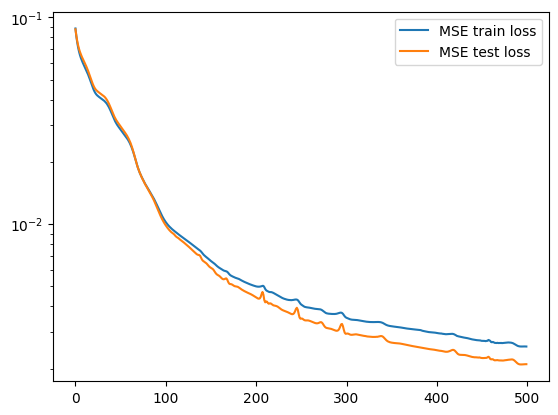

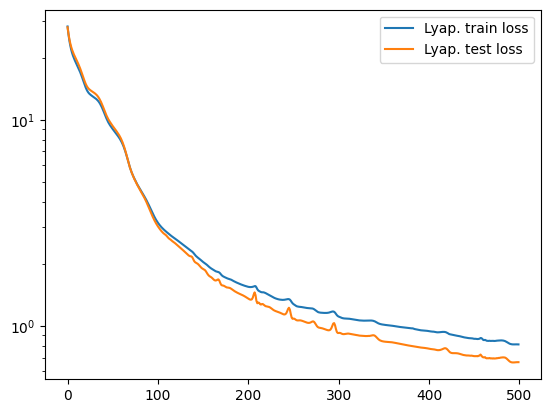

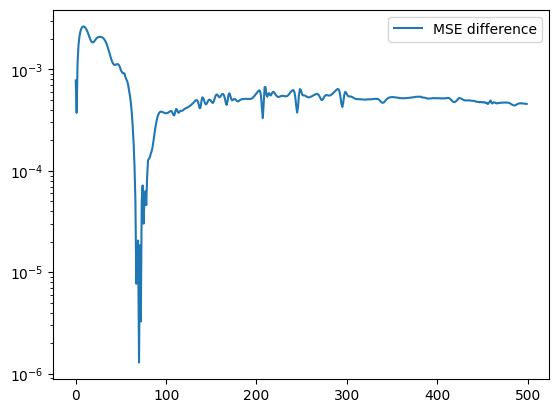

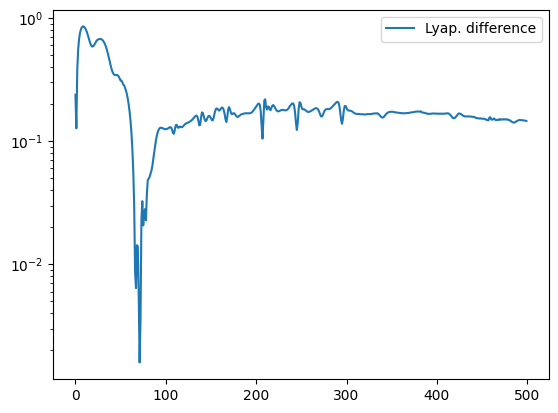

In [12]:
plt.plot(range(len(mse_train_losses)), np.array(mse_train_losses), label="MSE train loss")
plt.plot(range(len(mse_test_losses)), np.array(mse_test_losses), label="MSE test loss")
plt.yscale('log')
plt.legend()
plt.show()
plt.plot(range(len(lyap_train_losses)), np.array(lyap_train_losses), label="Lyap. train loss")
plt.plot(range(len(lyap_test_losses)), np.array(lyap_test_losses), label="Lyap. test loss")
plt.yscale('log')
plt.legend()
plt.show()
plt.plot(range(len(mse_test_losses)), np.abs(np.array(mse_test_losses)-np.array(mse_train_losses)), label="MSE difference")
plt.yscale('log')
plt.legend()
plt.show()
plt.plot(range(len(lyap_test_losses)), np.abs(np.array(lyap_test_losses)-np.array(lyap_train_losses)), label="Lyap. difference")
plt.legend()
plt.yscale('log')
plt.show()